# 1. 트랜스포머와 인코더 디코더

## 인코더와 디코더 구조 되짚어보기

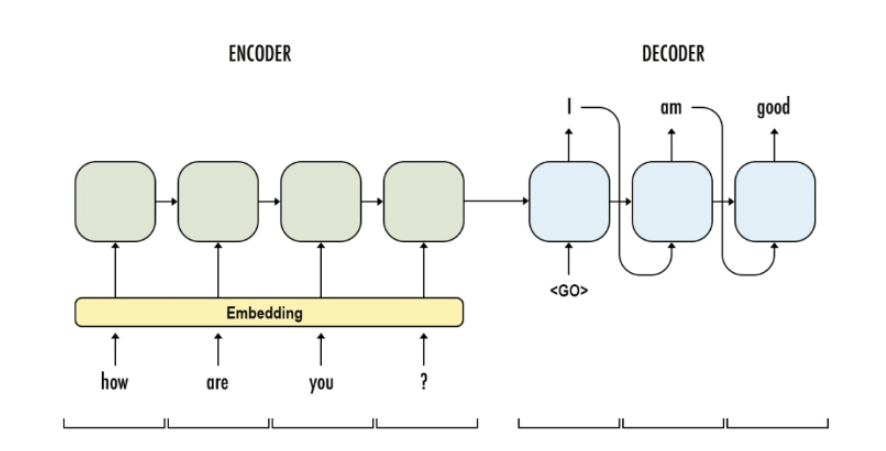

### 트랜스포머의 인코더와 디코더 

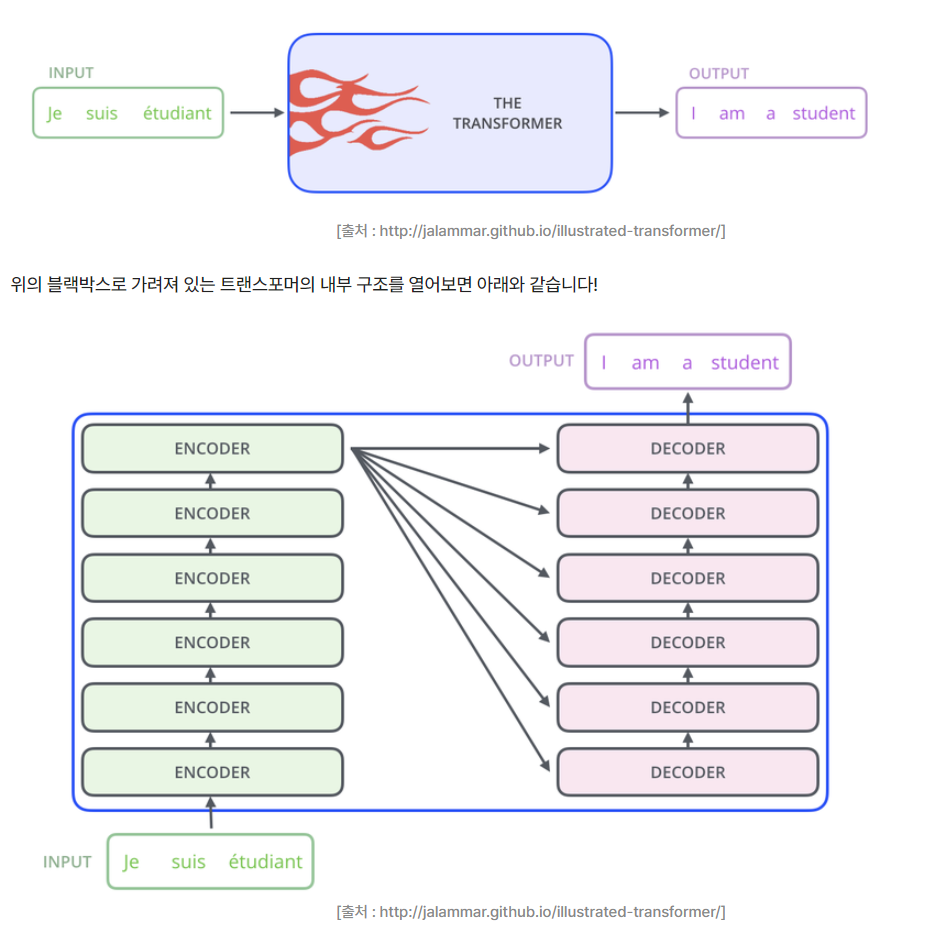
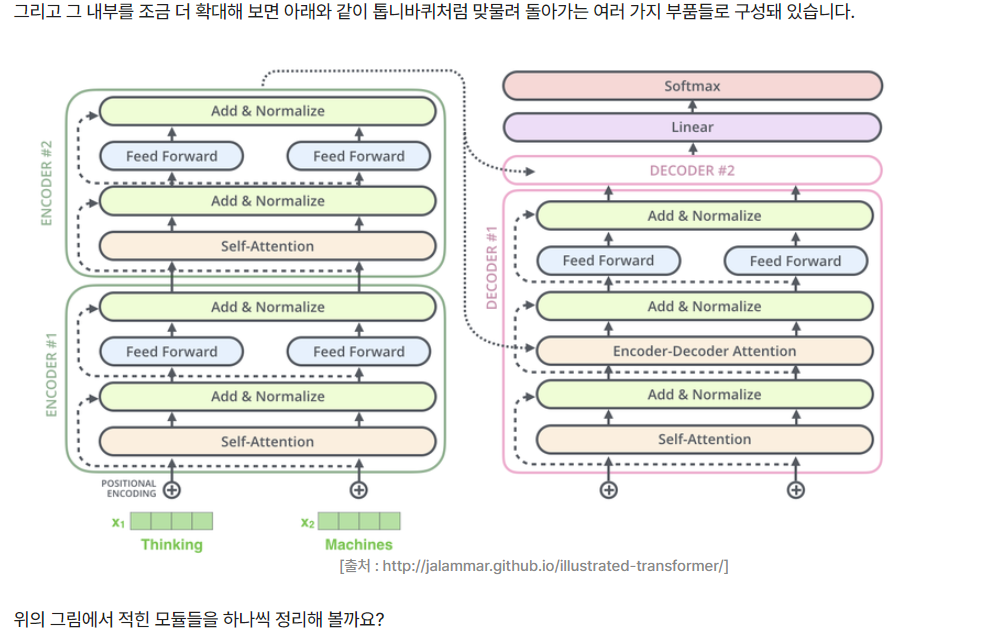
- 인코더 -  문장을 임베딩, 문자 의미 파악하여 디코더 전달
- 디코더 - 인코더에서 받은 정보 기반 문장 생성

# 2. 트랜스포머의 입력 이해하기 

- 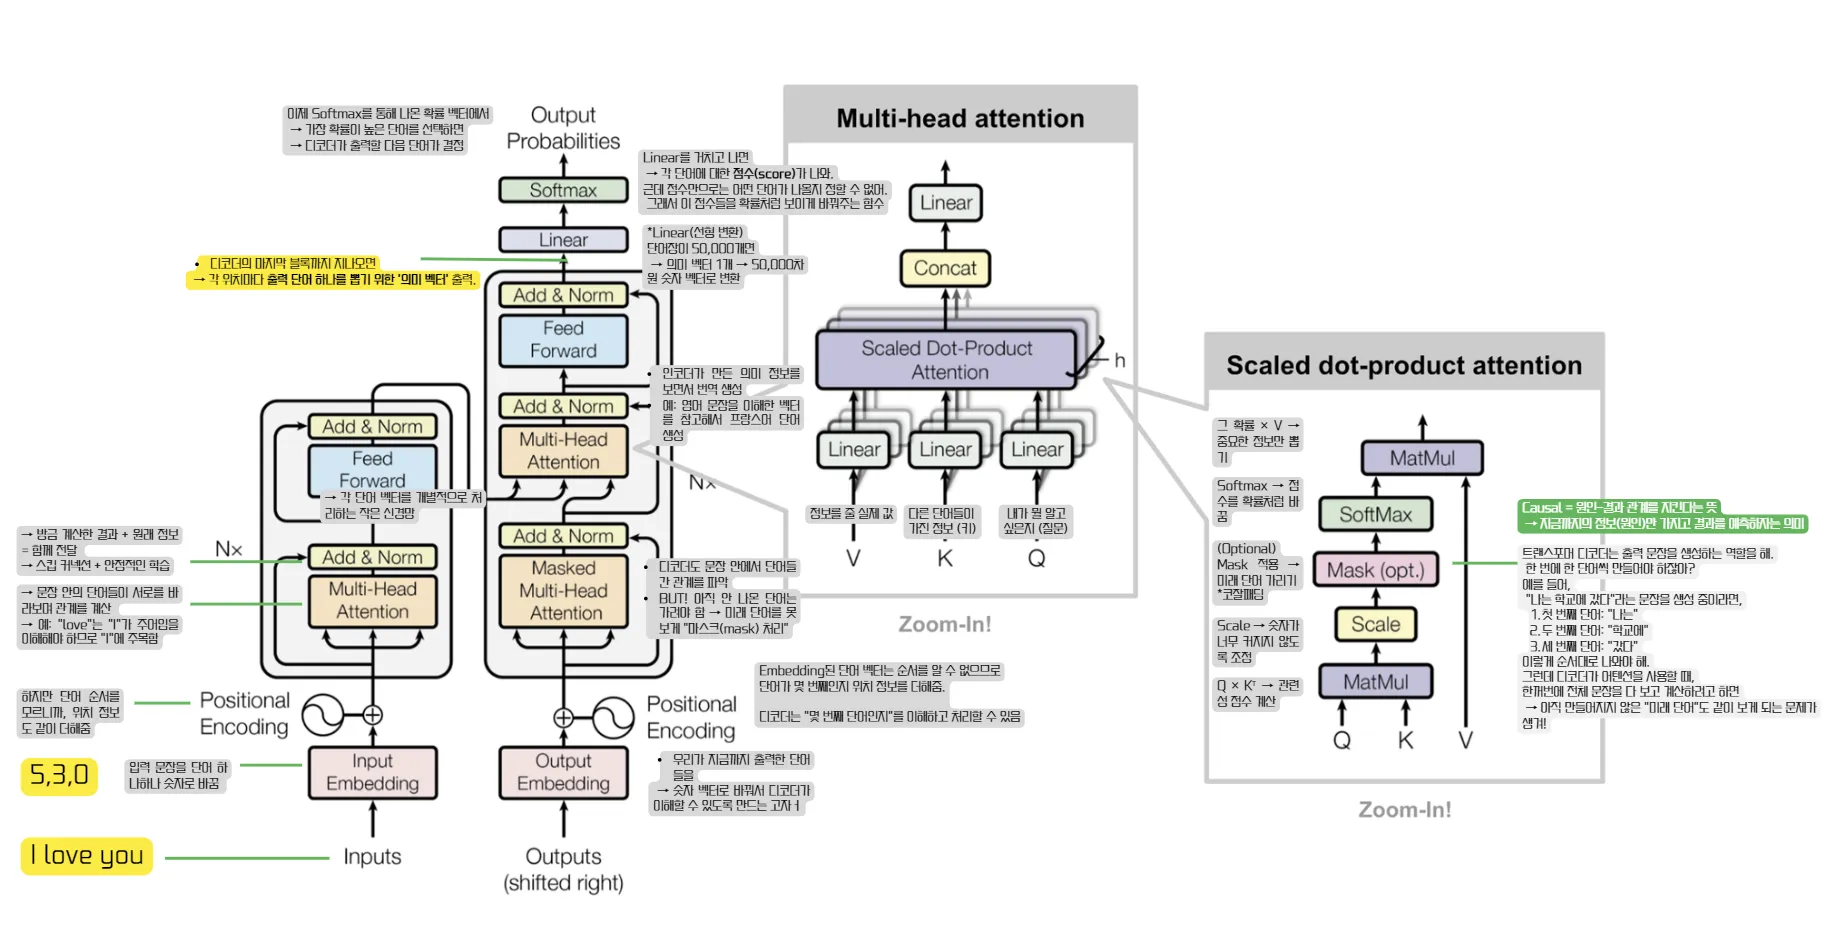
- gpt와 함께 트랜스포머 모델 메커니즘 이해를 돕기 위해 상세 주석을 단 이미지입니다. (승아)
- 관련해서 케창딥 때 정리한 내용 https://www.notion.so/modulabs/11-5-1c75c8e5427d802b9131c83b9df21da5 

## 2-1. 환경설정

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
print("슝=3")

슝=3


## 2-2. 포지셔닝 행렬 구현하기


트랜스포머는 RNN처럼 단어의 **순서 정보를 직접 다루지 않아.**

그래서 단어가 문장에서 **몇 번째 위치에 있는지** 알려주기 위해  
**위치 정보를 임베딩 벡터에 더해줘야 해!**

👉 이걸 **“포지셔널 인코딩(Positional Encoding)”**이라고 해.

---

### 🧮 포지셔널 인코딩 행렬이란?

> “단어 위치(position) + 차원(d_model)”에 따라 만들어진 **수학적인 위치 정보 테이블**

예를 들어서,  
`position=50`, `d_model=512` 라면,

- 행(row)은 위치(0~49)
- 열(column)은 임베딩 차원(0~511)

#### 🔢 포지셔널 행렬의 모양: `(50, 512)`  
이 행렬 안에 들어가는 값은  
**사인(sin)**과 **코사인(cos)** 함수로 계산돼.

---

### ✅ 왜 사인/코사인을 쓰나요?

- 사인/코사인은 **주기적인 패턴**을 가지고 있어서,  
  위치 정보가 **상대적 거리**로 표현돼.
- 예를 들어, 1번째와 2번째 위치는 유사한 패턴을 가지지만,  
  10번째와 50번째는 다른 패턴을 가지게 돼.

이걸 통해 모델은  
> “이 단어가 앞에 있구나”  
> “이 단어는 저 단어 바로 다음이네?”  
하는 걸 자연스럽게 파악할 수 있어.

포지셔널 행렬을 직접 구현해서 눈으로 확인해 봅시다!

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


### 🎨 시각적으로 보면?

`plt.pcolormesh(pos_encoding[0], cmap='RdBu')`  
이렇게 그리면 포지셔널 인코딩 행렬이  
**이런 식의 열-패턴이 보이는 이미지**로 나타나:


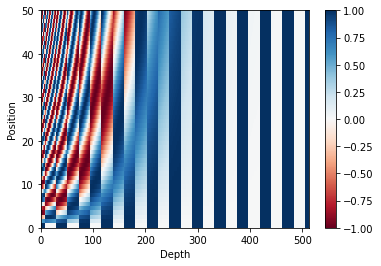

In [3]:
# Q.위의 문장처럼 행의 크기가 50, 열의 크기가 512인 행렬을 만드는 코드를 완성하여 입력 벡터 모양을 시각화하세요.

sample_pos_encoding = PositionalEncoding(position=50, d_model=512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()




| 개념 | 설명 |
|------|------|
| **포지셔널 인코딩** | 위치 정보를 표현하는 벡터 |
| **행렬 형태** | (position, d_model) |
| **계산 방식** | sin/cos 함수 기반 |
| **이유** | 순서가 없는 트랜스포머에 “단어 위치”를 알려주기 위해 |

# 3. 어텐션

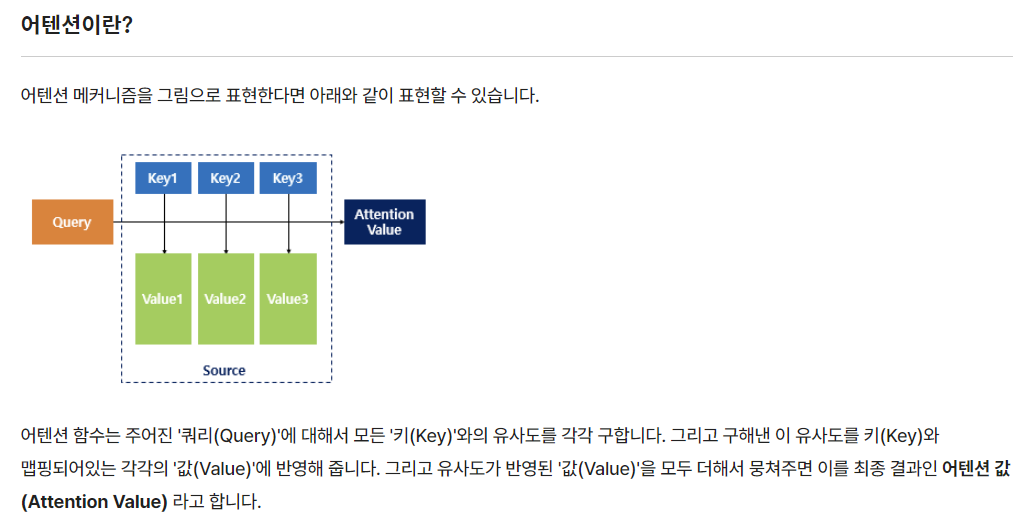

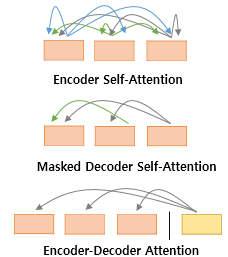

- 첫 번째 그림인 인코더 셀프 어텐션은 인코더에서 이루어지고,

- 두 번째 그림인 디코더 셀프 어텐션은 디코더에서 이루어지며,

- 세 번째 그림인 인코더-디코더 어텐션 또한 디코더에서 이루어집니다.

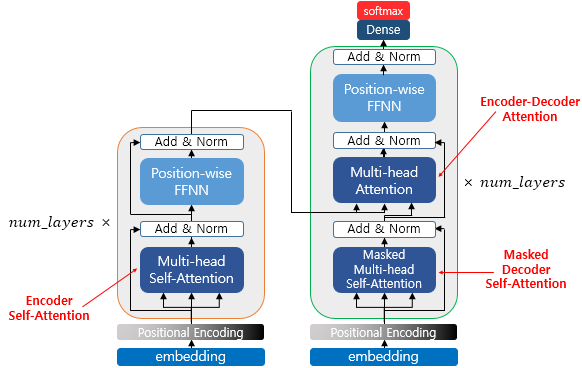

기계가 문장을 읽을 때, **어떤 단어가 중요한지** 알아차리는 방법이 바로 **어텐션(attention)** 이야.

사람도 문장 읽을 때 ‘이게 무슨 뜻이지?’ 하고 **중요한 단어에 집중**하잖아?  
기계도 똑같이 흉내 내는 거야.

---

### 👀 셀프 어텐션(Self-Attention)은 뭐냐면?

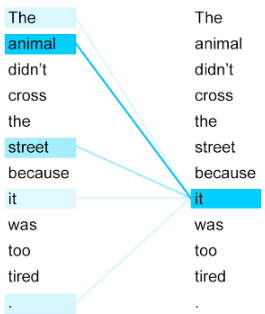

> 같은 문장 안에서 **단어들끼리 서로를 바라보며** 얼마나 관련 있는지를 계산하는 거야.

예를 들어:

> **"그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤했기 때문이다."**

여기서 "그것(it)"이 뭘까?  
**동물(animal)** 이겠지?

셀프 어텐션은 이런 식으로 **문장 안의 단어들끼리 서로 연결고리를 찾는 거야.**

---

### 🧩 그런데! "셀프 어텐션을 쓰지 않는 어텐션" 도 있어?

네! 그게 바로…

#### 🎯 인코더-디코더 어텐션 (Encoder-Decoder Attention)

- 이건 **두 문장 사이의 연결**을 찾아!
- 예를 들어, 한국어 문장 "**저는 학생입니다**"를 영어로 번역할 때,  
  디코더가 "I am a student"을 생성할 때  
  각각의 영어 단어("I", "am", ...)가  
  **원래 한국어 입력 문장 중 어떤 단어와 관련 있는지**를 보는 거야!

즉,
- **셀프 어텐션**: 한 문장 안의 단어들끼리 서로 보는 거
- **인코더-디코더 어텐션**: **입력 문장**과 **출력 문장** 사이를 보는 거


| 어텐션 종류              | 어떤 걸 비교해?                         | 셀프 어텐션? |
|-----------------------|--------------------------------------|---------------|
| 셀프 어텐션 (Self)     | **같은 문장 안의 단어들**             | ✅ 사용함     |
| 인코더-디코더 어텐션   | 입력 문장 vs 출력 문장               | ❌ 사용 안 함 |
| 디코더 셀프 어텐션     | 디코더에서 생성 중인 단어들끼리 비교 | ✅ 사용함     |


# 4. 스케일드 닷 프로덕트 어텐션

스케일드 닷 프로덕트 어텐션은 어텐션을 계산하는 **한 가지 방식**이야.  
여기서 중요한 건 3가지 벡터:

- **Q (Query)**: 찾으려는 단어의 벡터
- **K (Key)**: 다른 단어들의 대표 정보
- **V (Value)**: 실제로 참고할 정보

### 계산 과정은 이렇게 돼:

#### ✨ 공식:

```
Attention(Q, K, V) = softmax((Q × Kᵀ) / √d_k) × V
```

--
#### ✅ 1) Q와 K의 내적 → **유사도 계산**

- Q는 지금 기준이 되는 단어
- K는 문장 속 모든 단어들
- `Q × Kᵀ`를 하면, 지금 단어가 **다른 단어들과 얼마나 관련 있는지** 숫자로 나옴

> 📏 내적 = 관련도 점수

---

#### ✅ 2) `√d_k`로 나누기 → **스케일링 (중요!)**

벡터 차원이 크면, 내적값이 너무 커져서 softmax가 폭주함 😱  
그래서 숫자를 안정화시키기 위해 **스케일링** 해줘:

```python
scores = (Q × Kᵀ) / √d_k
```

---

#### ✅ 3) softmax → **가중치로 변환**

유사도 점수를 softmax로 바꾸면  
**합이 1인 확률 분포**가 돼.

> "이 단어는 70%, 저 단어는 20%, 나머지는 별로야~"

---

#### ✅ 4) V와 곱하기 → **최종 어텐션 결과**

가중치를 V에 곱해서  
“어떤 단어에서 얼마나 정보를 가져올지” 결정!

---

```
           Query (Q)
              ↓
          [유사도 계산]
      Q × Kᵀ → 점수
              ↓
         [스케일링]
         나누기 √d_k
              ↓
         [Softmax]
         확률 가중치
              ↓
         [Value 가중합]
        최종 어텐션 출력
```



스케일드 닷 프로덕트 어텐션 함수를 구현해봅시다.

In [4]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


# 5. 멀티 헤드 어텐션

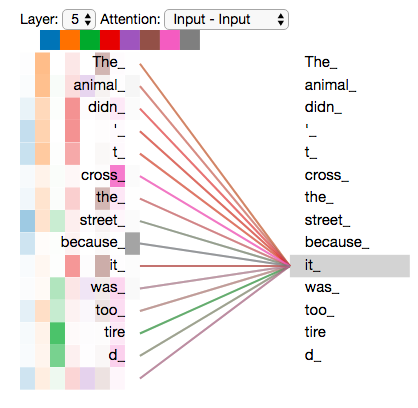

> **멀티헤드 어텐션은 하나의 어텐션이 볼 수 없는 복잡한 관계를,  
> 여러 관점으로 동시에 바라볼 수 있게 해주는 구조!**


한 개의 어텐션만 보면,  
단어들 사이의 관계를 **한 가지 관점**에서밖에 볼 수 없어.

하지만, 단어의 관계는 복잡하지!

- 어떤 헤드는 **문법적 관계**를 볼 수도 있고
- 어떤 헤드는 **의미적 유사성**을 볼 수도 있어

그래서 트랜스포머는 어텐션을 여러 개 "병렬로" 계산함!

---

## 📌 핵심 개념 요약

| 단계 | 설명 |
|------|------|
| 1. Q, K, V 생성 | 입력에서 Query, Key, Value 벡터를 만듦 |
| 2. 분할(split) | Q, K, V를 여러 개의 "머리(head)"로 나눔 |
| 3. 각각 어텐션 수행 | 각 헤드에서 **Scaled Dot-Product Attention** 수행 |
| 4. 다시 합치기 | 모든 헤드를 연결(concat) |
| 5. Dense 통과 | 최종 출력을 만들어냄 |

---

## 🧠 구조 그림 (텍스트로 표현하면)

```
Input
  │
Q, K, V 생성
  │
Split → ┌────────────┐
        │ Head 1     │ → 어텐션 계산
        │ Head 2     │ → 어텐션 계산
        │ ...        │
        │ Head n     │
        └────────────┘
  ↓
Concat → Dense → Output
```

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)  # (batch_size, seq_len, d_model)
    key = self.key_dense(key)        # (batch_size, seq_len, d_model)
    value = self.value_dense(value)  # (batch_size, seq_len, d_model)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    key = self.split_heads(key, batch_size)      # (batch_size, num_heads, seq_len_k, depth)
    value = self.split_heads(value, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    # 결과: (batch_size, num_heads, seq_len_q, depth)

    # 어텐션 결과를 다시 결합
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    # 최종 Dense 레이어 적용
    outputs = self.dense(concat_attention)

    return outputs


# 6. 마스킹

## 패딩 마스킹(Padding Masking)

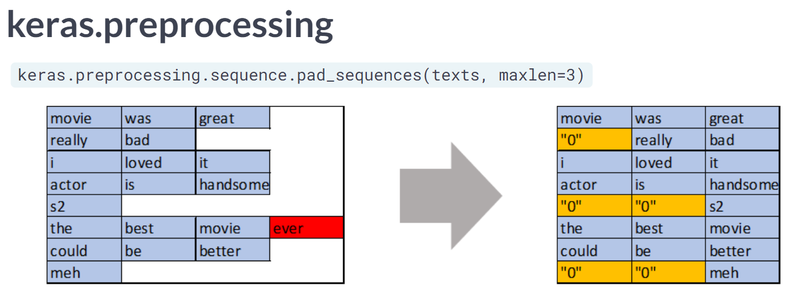

패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해준 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법입니다.

위 그림은 케라스의 pad_sequences()를 사용하여 패딩을 하는 과정을 시각화한 그림입니다.

그런데 사실 이렇게 주어진 숫자 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외할 필요가 있습니다. 패딩 마스킹은 이를 위해 숫자 0인 위치를 체크합니다.

In [6]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [7]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


## 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)

하지만 트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있습니다. 하지만 사실 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것입니다. 따라서 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 기법입니다.

이 기법은 어텐션을 수행할 때, Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹 합니다.

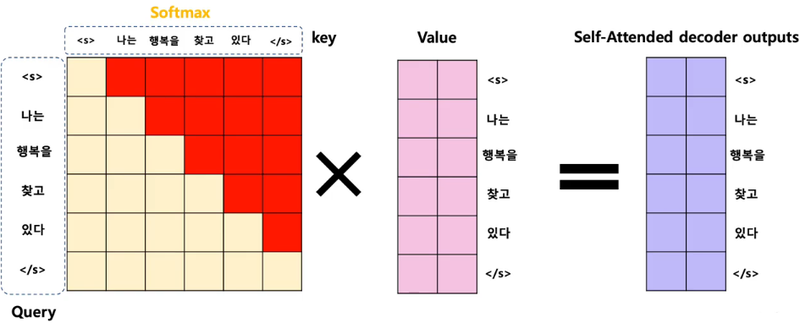

위의 그림에서 빨간색으로 색칠된 부분은 마스킹을 표현하고 있습니다. 빨간색은 실제 어텐션 연산에서 가리는 역할을 하여 어텐션 연산 시에 현재 단어를 기준으로 이전 단어들하고만 유사도를 구할 수 있습니다. 행을 Query, 열을 Key로 표현된 행렬임을 감안하고 천천히 행렬을 살펴봅시다.

예를 들어 Query 단어가 '찾고'라고 한다면, 이 '찾고'라는 행에는 <s>, <나는>, <행복을>, <찾고>까지의 열만 보이고 그 뒤 열은 아예 빨간색으로 칠해져 있습니다. 즉, 유사도를 구할 수 없도록 해놓았습니다. 저 빨간색 부분을 마스킹 함수로 구현하면 다음과 같습니다.

In [8]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [9]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


대각선의 형태로 숫자 1이 채워지는 것을 볼 수 있습니다. 그런데 이 마스킹과 패딩 마스킹은 별개이므로, 이 마스킹을 수행할 때 만약에 숫자 0인 단어가 있다면 이 또한 패딩 해야 합니다. 그래서 create_look_ahead_mask() 함수는 내부적으로 앞서 구현한 패딩 마스크 함수도 호출하고 있습니다.

In [10]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


# 7. 인코더

## 인코더 층 만들기

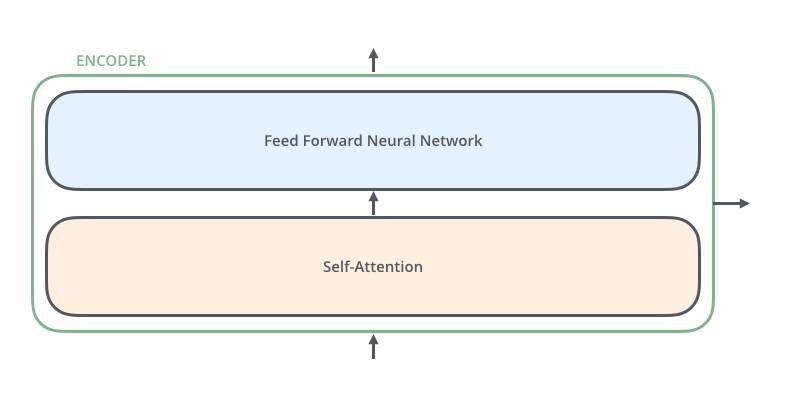

하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어집니다.
바로 셀프 어텐션과 피드 포워드 신경망입니다. 셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어집니다.

두 개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수는 다음과 같습니다. 함수 내부적으로 첫 번째 서브 층과 두 번째 서브 층을 구현하고 있습니다.

In [11]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


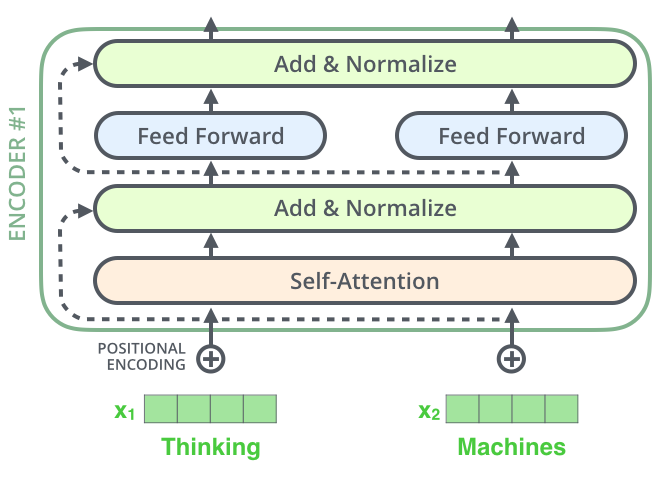

## 인코더 층을 쌓아 인코더 만들기

이렇게 구현한 인코더 층을 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성됩니다.

인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용되었습니다. 위 그림에서는 Normalize라고 표시된 부분에 해당됩니다.

트랜스포머는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓습니다. 논문에서는 총 6개의 인코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다 

### 📌 트랜스포머 논문에서 왜 6개 썼을까?

- 원래 [“Attention is All You Need”](https://arxiv.org/abs/1706.03762) 논문에서는  
  **인코더 6개 + 디코더 6개**를 사용했어.
- 이게 성능과 학습 시간 사이의 **트레이드오프 균형**이 가장 좋았기 때문이야.
- 실제로 이후 대형 모델들은 더 많이 쌓음:
  - **BERT-base**: 12개의 인코더
  - **BERT-large**: 24개
  - **GPT-3**: 무려 96개 이상!


#### 🔼 장점 (많이 쌓을수록)

1. **더 복잡한 패턴 학습 가능**
   - 문장에서 멀리 떨어진 단어들 간의 복잡한 관계도 잘 잡아냄
   - 고차원적 문맥 이해 가능

2. **성능 향상 (충분한 데이터/자원이 있다면)**
   - 특히 번역, 요약, 질의응답 등에서 높은 성능

3. **더 깊은 피처 추출**
   - 초기 층은 단순한 정보, 뒤로 갈수록 고급 의미 포착

---

#### ❌ 단점 (너무 많으면)

1. **학습 시간 증가**
   - 연산량 폭발 → GPU 메모리와 시간이 더 필요함

2. **과적합 위험**
   - 데이터가 적은데 층만 많으면 학습은 잘 되지만, 실제 성능은 떨어짐

3. **그래디언트 소실/폭주 가능성**
   - 너무 깊으면 안정적인 학습이 어려울 수도 있음  
     (이 문제는 Layer Normalization + Residual Connection으로 어느 정도 해결)

---

```
입력 문장: "나는 학생이다"

┌──────────────────────────────┐
│ Encoder Layer 0 → 단어 의미 + 위치 │ 🎨 단어의 존재 파악
├──────────────────────────────┤
│ Encoder Layer 1 → 인접 단어 연결     │ 🔗 구문 구조 이해
├──────────────────────────────┤
│ Encoder Layer 2 → 문맥 학습         │ 📚 문장의 흐름 이해
├──────────────────────────────┤
│ Encoder Layer 3 → 참조관계 파악      │ 👀 대명사, 주어 연결
├──────────────────────────────┤
│ Encoder Layer 4 → 의미 통합         │ 🧠 추론, 감정 파악
├──────────────────────────────┤
│ Encoder Layer 5 → 전체 맥락 요약     │ 🎯 디코더에 줄 핵심 정보
└──────────────────────────────┘
```


각 인코더는 **멀티헤드 어텐션 + 피드포워드 신경망 + LayerNorm** 으로 구성되어 있어요.  
그리고 각각의 층은 **점점 더 복잡하고 추상적인 정보를 학습**합니다.

---

#### 🧱 Encoder Layer 0 (맨 처음 층)
- **표면적 정보 학습**
- 단어의 의미(embedding) + 위치 정보(positional encoding)를 결합
- 예: "학생(student)"이 어떤 단어인지는 알지만, **문맥은 아직 모름**

> 👉 역할: 단어를 숫자로 표현하고, 위치 인코딩으로 순서를 반영

---

#### 🔗 Encoder Layer 1~2
- **짧은 거리 관계 학습**
- 가까이 있는 단어들과의 연결을 주로 이해함  
- 예: "나는 학생이다" → "나는"과 "학생이다"의 관계 포착

> 👉 역할: 문장 구조 이해 시작

---

#### 🧠 Encoder Layer 3~4
- **의미 있는 문맥 관계 학습**
- 더 멀리 있는 단어 사이의 관계까지 고려
- 예: "왜냐하면 그것은 피곤했기 때문이다" → “그것”이 “동물”을 의미하는 걸 파악

> 👉 역할: 문맥 속 참조 관계, 시제, 감정 등 추상적 정보 이해

---

#### 🎯 Encoder Layer 5~6 (최상단 층)
- **고차원 추론과 의미 결합**
- 문장의 전체적인 의미, 질문-답변의 연결, 감정 판단 등  
- 예: 이 문장이 긍정인지, 질문인지, 번역 시 어순이 바뀌는지를 결정

> 👉 역할: 최종적으로 디코더에 넘길 **의미 압축 정보**를 완성

---

In [12]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


# 8. 디코더

디코더는 인코더와 비슷하지만, 인코더보다 조금 더 복잡합니다. 인코더는 두 개의 서브 층으로 구성되지만, 디코더는 세 개의 서브 층으로 구성된다는 점이 다릅니다.

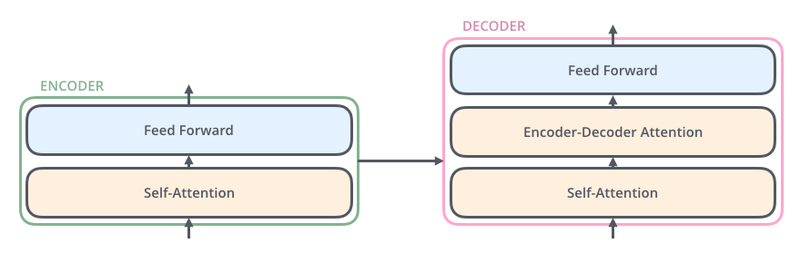

첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망입니다. 인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있습니다. 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정입니다.

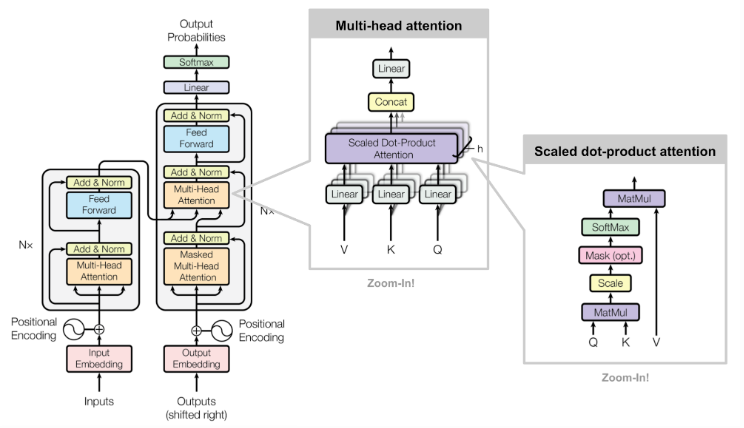

인코더의 셀프 어텐션과 마찬가지로 디코더의 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행합니다.

In [13]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


## 디코더 층을 쌓아 디코더 만들기

이렇게 구현한 디코더의 층은 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성됩니다.

인코더와 마찬가지로 num_layers 개수의 디코더 층을 쌓습니다. 논문에서는 총 6개의 디코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다.

In [14]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


# 9. 한국어 데이터로 챗봇 만들기

여기서는 Cornell Movie-Dialogs Corpus라는 영화 및 TV 프로그램에서 사용되었던 대화의 쌍으로 구성된 데이터셋을 사용합니다. 대화의 쌍이라고 하는 것은 기본적으로 먼저 말하는 사람의 대화 문장이 있고, 그에 응답하는 대화 문장의 쌍으로 이루어집니다.

데이터를 받아오는 이번 스텝에서 목표로 하는 것은 다음과 같습니다.

정해진 개수인 50,000개의 질문과 답변의 쌍을 추출한다.
문장에서 단어와 구두점 사이에 공백을 추가한다.
알파벳과 ! ? , . 이 4개의 구두점을 제외하고 다른 특수문자는 모두 제거한다.

## Step 0. 라이브러리 임포트

In [15]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import urllib.request
import os

## Step 1. 데이터 수집하기

In [16]:
# 데이터셋 다운로드
url = "https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv"
urllib.request.urlretrieve(url, "ChatbotData.csv")

# 데이터 로드
train_data = pd.read_csv('ChatbotData.csv')
print(f"데이터 크기: {train_data.shape}")
print(train_data.head())

# 질문과 답변 분리
questions = train_data['Q'].values
answers = train_data['A'].values

데이터 크기: (11823, 3)
                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


## Step 2. 데이터 전처리하기

In [17]:
def preprocess_sentence(sentence):
    # 한글, 숫자, 공백을 제외한 모든 문자 제거
    sentence = re.sub(r"[^가-힣0-9\s]", "", sentence)
    # 공백 정리
    sentence = re.sub(r"\s+", " ", sentence)
    # 시작과 끝에 토큰 추가
    sentence = "<start> " + sentence.strip() + " <end>"
    return sentence

# 질문과 답변에 전처리 적용
processed_questions = [preprocess_sentence(q) for q in questions]
processed_answers = [preprocess_sentence(a) for a in answers]

# 데이터 분할
questions_train, questions_val, answers_train, answers_val = train_test_split(
    processed_questions, processed_answers, test_size=0.2, random_state=42
)

print(f"훈련 데이터: {len(questions_train)}")
print(f"검증 데이터: {len(questions_val)}")

훈련 데이터: 9458
검증 데이터: 2365


## Step 3. SubwordTextEncoder 사용하기

- **형태소 분석기**는 언어학적 의미 단위와 품사 정보를 제공하며, 한국어 등 교착어에 최적화되어 있으나 사전 관리와 신조어 반영에 한계가 있습니다.
- **서브워드 텍스트 인코더**는 OOV 문제를 해결하고 대규모 모델에 적합하지만, 의미 단위 분석과 품사 태깅에는 한계가 있습니다.
- 실제 NLP 프로젝트에서는 두 방법을 목적에 맞게 선택하거나, 보완적으로 함께 사용하기도 합니다.


### **1. 원리**

**형태소 분석기**
- 형태소 분석기는 문장을 의미를 가지는 최소 단위(형태소)로 분리하고, 각 형태소에 품사 정보를 부여하는 자연어 처리 도구입니다.
- 전통적으로는 규칙 기반(사전 및 문법 규칙) 접근법을 사용했으나, 최근에는 대량의 언어 데이터를 학습한 머신러닝 및 딥러닝 기반 모델이 주류입니다.
- 예를 들어, "나는 학교에 간다"라는 문장을 ["나", "는", "학교", "에", "가", "ㄴ다"]와 같이 형태소 단위로 분리하고, 각 형태소에 품사 태그를 부여합니다[1][4][7].

**서브워드 텍스트 인코더**
- 서브워드 인코더는 단어를 더 작은 단위(서브워드, subword)로 분할해 토큰화합니다.
- 대표적으로 BPE(Byte Pair Encoding), WordPiece, Unigram Language Model, SentencePiece 등의 알고리즘이 있습니다.
- 자주 등장하는 문자 또는 음절 쌍을 반복적으로 병합해 서브워드 사전을 만들고, 모든 단어를 이 사전의 서브워드 조합으로 표현합니다.
- OOV(Out-of-Vocabulary) 문제를 해결하기 위해 등장했으며, 신조어나 희귀 단어도 서브워드 단위로 분할해 처리할 수 있습니다[5][6][8][9][10].

---

### **2. 장점**

| 형태소 분석기 | 서브워드 텍스트 인코더 |
|:---|:---|
| - 의미 단위로 분리해 품사 정보를 제공, 문법적·의미적 분석에 유리- 한국어 등 교착어의 구조적 분석에 강점- 도메인 특화 품사 태깅 가능 | - OOV 문제 해결(신조어, 희귀어 처리 용이)- 언어에 독립적, 사전 없이도 적용 가능- 어휘 집합 크기를 효율적으로 조절- LLM 등 대규모 모델에 최적화 |

---

### **3. 단점**

| 형태소 분석기 | 서브워드 텍스트 인코더 |
|:---|:---|
| - 사전 구축 및 관리 필요(신조어, 도메인 특화 단어 반영 어려움)- 규칙 기반은 신속하지만 유연성 부족, 머신러닝 기반은 데이터와 연산 자원 필요- 언어별로 별도 개발 필요 | - 의미 단위가 아닌 임의의 문자 조합이 토큰이 될 수 있어 의미 해석에 한계- 품사 정보 제공 불가- 과도한 분할로 토큰 수 증가 가능- 언어별 특성 반영 어려움 |

---

### **4. 예시**

**형태소 분석기 예시**
- 입력: "나는 학교에 간다."
- 출력: ["나", "는", "학교", "에", "가", "ㄴ다"] (각각 품사 태그 포함)[4].

**서브워드 인코더 예시**
- 입력: "unhappiness"
- BPE 분할: ["un", "happiness"] 또는 ["un", "hap", "pi", "ness"] 등[8].
- 한국어 예시: "경찰차" → ["경찰", "차"][8].

---
## 대표적인 형태소 분석기 & 서브워드 인코더와 설치/사용 링크

### **형태소 분석기**

| 이름       | 특징/설명 | 설치/사용 링크 |
|:-----------|:----------|:---------------|
| **Khaiii** | 카카오에서 개발한 딥러닝(CNN) 기반 한국어 형태소 분석기. Python 지원, 높은 정확도와 속도. | [GitHub - khaiii](https://github.com/kakao/khaiii)[1][10] |
| **Komoran** | 자바 기반, 규칙+데이터 기반 하이브리드. Python용 PyKOMORAN도 제공. | [공식 문서](https://docs.komoran.kr)[2][11] |
| **Mecab** | 매우 빠르고 가벼운 C++ 기반, 다양한 언어 지원. Python 연동 가능. | [설치 가이드](https://jjstory82.tistory.com/58)[3] |
| **Okt (Open Korean Text)** | 트위터에서 개발, Python에서 konlpy로 쉽게 사용 가능. | [konlpy 공식](https://konlpy.org/ko/latest/) 또는 [사용 예시](https://todaycodeplus.tistory.com/43)[4] |
| **Kkma** | 서울대 IDS 연구실 개발, Java/Python 지원, 문장 단위 분석 강점. | [GitHub - kkma_python](https://github.com/YuJungChae/kkma_python)[5] |
| **Hannanum** | KAIST 개발, 22개 형태소 태그 제공, Python 지원. | [Hama NLP 문서](https://hamanlp.org/docs/morphemes/)[6] |

---

### **서브워드 텍스트 인코더**

| 이름        | 특징/설명 | 설치/사용 링크 |
|:------------|:----------|:---------------|
| **SentencePiece** | 구글 개발, BPE/Unigram 등 다양한 서브워드 분할 지원. 언어 독립적, Python/C++ 지원. | [GitHub - SentencePiece](https://github.com/google/sentencepiece)[7] |
| **Byte Pair Encoding (BPE)** | 가장 널리 쓰이는 서브워드 알고리즘. 다양한 구현체 존재. | [Python 구현체](https://github.com/teleprint-me/byte-pair)[8], [py-bpe](https://github.com/mirandrom/py-bpe)[12] |
| **WordPiece** | BERT, KoBERT 등에서 사용, 단어 내부에 ##로 서브워드 구분. | [Huggingface Tokenizers WordPiece](https://github.com/huggingface/tokenizers/blob/master/tokenizers/src/decoders/wordpiece.rs)[9], [KoELECTRA WordPiece 예시](https://github.com/monologg/KoELECTRA/blob/master/docs/wordpiece_vocab_EN.md)[13], [R 패키지 wordpiece](https://github.com/macmillancontentscience/wordpiece)[14] |

---

### 1. 단어장(Vocabulary) 만들기

In [18]:
# 질문과 답변을 하나의 리스트로 결합하여 토크나이저 생성
all_sentences = list(questions_train) + list(answers_train)

# SubwordTextEncoder 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    all_sentences, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고정된 인덱스 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [19]:
# 최대 길이 설정
MAX_LENGTH = 40

In [20]:
# 토큰화 함수
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 토큰화 및 시작/종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # 길이 제한 확인
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    # 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [21]:
# 데이터셋 생성
questions_train_tokens, answers_train_tokens = tokenize_and_filter(questions_train, answers_train)
questions_val_tokens, answers_val_tokens = tokenize_and_filter(questions_val, answers_val)

### 3. 교사 강요(Teacher Forcing) 사용하기

> “기계야, 네가 예측하지 말고, **정답을 그대로 받아서 공부해!**”

이게 교사강요야.

---

우리가 기계에게 이런 문장을 번역하게 시켜보자:

#### 한국어: 저는 학생입니다  
#### 영어: I am a student

우리가 기계에게 영어 문장을 하나씩 만들게 시킬 때,

---

#### ✅ **교사강요를 쓰면?**

기계가 예측할 차례에  
우리는 **기계가 예측한 결과**가 아니라  
**정답**을 강제로 넣어줘!

| 단계 | 기계가 받아들이는 입력 | 기대 출력 |
|------|------------------|------------|
| 1    | `<start>`         | `I`        |
| 2    | `I`               | `am`       |
| 3    | `am`              | `a`        |
| 4    | `a`               | `student`  |

→ 계속 **정답을 넣어주며 훈련**시킴.

---

#### ❌ 교사강요를 안 쓰면?

기계가 **자기 스스로 예측한 결과**를  
그 다음 입력으로 써.

| 단계 | 기계가 입력으로 쓰는 것 | 기대 출력 |
|------|-------------------|------------|
| 1    | `<start>`          | `I`        |
| 2    | `기계가 예측한 단어` | `am`       |
| 3    | `기계가 예측한 단어` | `a`        |

→ 만약 첫 단추를 틀리면, **계속 오류가 누적될 수 있어!**  
(이걸 **노출 편향(Exposure Bias)**이라고도 해)

---

**요약**

| 항목              | 설명 |
|-----------------|------|
| 목적             | 훈련 시 **빠르고 안정적으로 학습**하게 함 |
| 방식             | **정답을 강제로 넣어줌** |
| 장점             | 훈련이 잘 됨, 빠름 |
| 단점             | 나중에 실제 사용 시에는 **정답이 없기 때문에 갭이 생김** |


In [22]:
# 텐서플로우 데이터셋 생성
BATCH_SIZE = 64
BUFFER_SIZE = 20000

In [39]:
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions_train_tokens,
        'dec_inputs': answers_train_tokens[:, :-1]
    },
    answers_train_tokens[:, 1:]  # 'outputs' 키를 제거하고 텐서를 직접 전달
))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 구성하기

In [40]:
# 트랜스포머 모델 클래스
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, num_layers, units, d_model, num_heads, dropout):
        super().__init__()
        self.encoder = encoder(vocab_size=vocab_size,
                               num_layers=num_layers,
                               units=units,
                               d_model=d_model,
                               num_heads=num_heads,
                               dropout=dropout)
        
        self.decoder = decoder(vocab_size=vocab_size,
                               num_layers=num_layers,
                               units=units,
                               d_model=d_model,
                               num_heads=num_heads,
                               dropout=dropout)
        
        self.final_layer = tf.keras.layers.Dense(vocab_size)
    
    def call(self, inputs):
        inp = inputs['inputs']
        dec_inp = inputs['dec_inputs']
        
        enc_padding_mask = create_padding_mask(inp)
        dec_padding_mask = create_padding_mask(inp)
        look_ahead_mask = create_look_ahead_mask(dec_inp)
        
        enc_output = self.encoder(inputs=[inp, enc_padding_mask])
        dec_output = self.decoder(inputs=[dec_inp, enc_output, look_ahead_mask, dec_padding_mask])
        
        final_output = self.final_layer(dec_output)
        
        return final_output

## 1. 모델 생성

논문에서 num_layers는 6, d-Model은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용합니다.

In [41]:
# 모델 파라미터
NUM_LAYERS = 4
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

# 모델 생성
model = Transformer(vocab_size=VOCAB_SIZE,
                    num_layers=NUM_LAYERS,
                    units=UNITS,
                    d_model=D_MODEL,
                    num_heads=NUM_HEADS,
                    dropout=DROPOUT)

In [42]:
model.build({'inputs': (None, MAX_LENGTH), 'dec_inputs': (None, MAX_LENGTH)})

In [43]:
model.summary()

Model: "transformer_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         (None, None, 256)         4347904   
_________________________________________________________________
decoder (Functional)         (None, None, 256)         5402624   
_________________________________________________________________
dense_194 (Dense)            multiple                  2248236   
Total params: 11,998,764
Trainable params: 11,998,764
Non-trainable params: 0
_________________________________________________________________


## 2. 커스텀 된 학습률(Learning rate)

딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있습니다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 합니다.

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용합니다. 논문에 나온 공식은 다음과 같습니다.

In [44]:
# 학습률 스케줄러 (수정된 버전)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    def get_config(self):
        return {
            "d_model": self.d_model,
            "warmup_steps": self.warmup_steps
        }

## 3. 손실 함수(Loss function)

In [45]:
# 옵티마이저
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 손실 함수
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

Text(0.5, 0, 'Train Step')

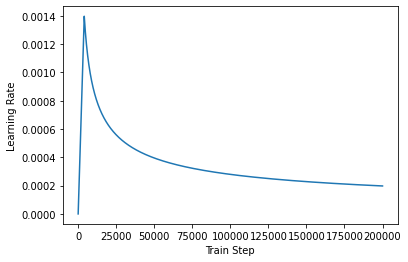

In [46]:
#학습률 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 4. 모델 컴파일

In [47]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

## Step 5. 모델 학습 및 평가하기

In [48]:
# 체크포인트 디렉토리 생성
checkpoint_path = "training_checkpoints"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 설정
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path + "/ckpt_{epoch}",
    save_weights_only=True,
    save_best_only=True,
    monitor='loss',
    verbose=1
)

# 조기 종료 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

In [49]:
# 조기 종료 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

In [50]:
# Learning Rate 로깅 콜백 
class LRLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if hasattr(self.model.optimizer, 'learning_rate'):
            if callable(self.model.optimizer.learning_rate):
                lr = self.model.optimizer.learning_rate(tf.cast(self.model.optimizer.iterations, tf.float32))
            else:
                lr = self.model.optimizer.learning_rate
            
            if hasattr(lr, 'numpy'):
                lr_value = lr.numpy()
            else:
                lr_value = float(lr)
            
            print(f'\nLearning rate for epoch {epoch + 1} is {lr_value}')

lr_logger = LRLogger()

In [51]:
# 학습
EPOCHS = 20
history = model.fit(
    dataset, 
    epochs=EPOCHS,
    callbacks=[checkpoint_callback, early_stopping, lr_logger]
)


Epoch 1/20
148/148 [==============================] - 24s 86ms/step - loss: 2.4632 - accuracy: 0.0630

Epoch 00001: loss improved from inf to 2.46319, saving model to training_checkpoints/ckpt_1

Learning rate for epoch 1 is 3.6563837056746706e-05
Epoch 2/20
148/148 [==============================] - 13s 86ms/step - loss: 1.7923 - accuracy: 0.1787

Epoch 00002: loss improved from 2.46319 to 1.79230, saving model to training_checkpoints/ckpt_2

Learning rate for epoch 2 is 7.312767411349341e-05
Epoch 3/20
148/148 [==============================] - 13s 86ms/step - loss: 1.2120 - accuracy: 0.1795

Epoch 00003: loss improved from 1.79230 to 1.21196, saving model to training_checkpoints/ckpt_3

Learning rate for epoch 3 is 0.00010969150753226131
Epoch 4/20
148/148 [==============================] - 13s 87ms/step - loss: 0.9670 - accuracy: 0.1808

Epoch 00004: loss improved from 1.21196 to 0.96702, saving model to training_checkpoints/ckpt_4

Learning rate for epoch 4 is 0.000146255348226986

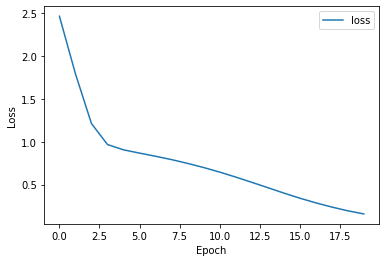

In [52]:
# 손실 그래프 그리기
plt.plot(history.history['loss'], label='loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [53]:
# 최종 모델 저장
model.save_weights(checkpoint_path + "/final_model_weights")
print("Final model weights saved!")

Final model weights saved!


## Step 5.1. 모델 로드하기 (필수x)

In [ ]:
# 저장된 모델 가중치 로드
def load_model_from_checkpoint(model, checkpoint_path):
    """저장된 체크포인트에서 모델 가중치를 로드합니다."""
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_path)
    if latest_checkpoint:
        model.load_weights(latest_checkpoint)
        print(f"Loaded weights from {latest_checkpoint}")
    else:
        print("No checkpoint found.")
    return model

In [ ]:
# 새로운 모델 인스턴스 생성
new_model = Transformer(vocab_size=VOCAB_SIZE,
                       num_layers=NUM_LAYERS,
                       units=UNITS,
                       d_model=D_MODEL,
                       num_heads=NUM_HEADS,
                       dropout=DROPOUT)

In [ ]:
# 컴파일
new_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

## Step 5.2. 학습 재개하기 (필수x)

In [ ]:
# 이전 학습에서 중단된 부분부터 다시 시작하려면
initial_epoch = 10  # 예를 들어 10번째 에폭부터 다시 시작

# 학습 재개
history_resume = model.fit(
    dataset, 
    epochs=EPOCHS,
    initial_epoch=initial_epoch,
    callbacks=[checkpoint_callback, early_stopping, lr_logger]
)

## Step 5.3. 훈련 중간에 모델 평가하기 (필수x)

In [54]:
# 특정 체크포인트에서 모델 평가
def evaluate_checkpoint(model, checkpoint_path, test_sentences):
    """특정 체크포인트에서 모델을 평가합니다."""
    # 체크포인트 로드
    model.load_weights(checkpoint_path)
    
    # 테스트 문장으로 평가
    for sentence in test_sentences:
        predict(sentence)
        print('---')
    
    return model

In [57]:
# 체크포인트 목록 확인
checkpoints = tf.train.latest_checkpoint(checkpoint_path)
print(f"Available checkpoints: {checkpoints}")

Available checkpoints: training_checkpoints/final_model_weights


In [ ]:
# 특정 체크포인트 평가
if checkpoints:
    evaluate_checkpoint(model, checkpoints, test_sentences)

## Step 5.4. 모델 저장하기(tflite)

In [ ]:
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_path)
if latest_checkpoint:
    model.load_weights(latest_checkpoint)
    print(f"Loaded weights from {latest_checkpoint}")
else:
    print("No checkpoint found!")

In [66]:
@tf.function(input_signature=[
    tf.TensorSpec(shape=[None, MAX_LENGTH], dtype=tf.int32, name='inputs'),
    tf.TensorSpec(shape=[None, MAX_LENGTH], dtype=tf.int32, name='dec_inputs')
])
def serving_fn(inputs, dec_inputs):
    return model({'inputs': inputs, 'dec_inputs': dec_inputs})

In [64]:
# 2. TFLite를 위한 입력 시그니처 정의
input_signature = {
    'inputs': tf.TensorSpec(shape=[1, MAX_LENGTH], dtype=tf.int32),
    'dec_inputs': tf.TensorSpec(shape=[1, MAX_LENGTH], dtype=tf.int32)
}

In [67]:
# 3. SavedModel 저장
tf.saved_model.save(
    model, 
    'saved_model',
    signatures={'serving_default': serving_fn}
)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [68]:
# 4. TFLite로 변환
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')

In [69]:
# 변환 옵션 설정
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS  # TensorFlow 연산 지원 (트랜스포머에 필요)
]

# 동적 형상 지원
converter.experimental_enable_resource_variables = True
try:
    # TF 2.5 이상
    converter._experimental_lower_tensor_list_ops = False
except:
    # 이전 버전
    pass

# 변환 실행
try:
    tflite_model = converter.convert()
    # TFLite 모델 저장
    with open('chatbot_model.tflite', 'wb') as f:
        f.write(tflite_model)
    print("TFLite 모델이 성공적으로 저장되었습니다: chatbot_model.tflite")
except Exception as e:
    print(f"TFLite 변환 중 오류 발생: {e}")
    print("대안: 양자화 없이 변환을 시도합니다...")
    
    # 기본 설정으로 다시 시도
    simple_converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
    simple_converter.target_spec.supported_ops = [tf.lite.OpsSet.SELECT_TF_OPS]
    
    try:
        tflite_model = simple_converter.convert()
        with open('chatbot_model_simple.tflite', 'wb') as f:
            f.write(tflite_model)
        print("기본 TFLite 모델이 저장되었습니다: chatbot_model_simple.tflite")
    except Exception as e2:
        print(f"기본 변환도 실패: {e2}")
        print("트랜스포머 모델은 TFLite로 변환이 어려울 수 있습니다.")

TFLite 모델이 성공적으로 저장되었습니다: chatbot_model.tflite


# Step 6. 챗봇 대화 함수 만들기

In [58]:
def preprocess_sentence_for_chat(sentence):
    sentence = re.sub(r"[^가-힣0-9\s]", "", sentence)
    sentence = re.sub(r"\s+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [59]:
def evaluate(sentence):
    sentence = preprocess_sentence_for_chat(sentence)
    
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    output = tf.expand_dims(START_TOKEN, 0)
    
    for i in range(MAX_LENGTH):
        predictions = model(inputs={
            'inputs': sentence,
            'dec_inputs': output
        })
        
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
        
        output = tf.concat([output, predicted_id], axis=-1)
    
    return tf.squeeze(output, axis=0)

In [60]:
def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])
    
    # 마지막 '<end>' 토큰 제거
    predicted_sentence = predicted_sentence.replace('<end>', '').strip()
    
    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))
    
    return predicted_sentence

In [61]:
# 챗봇 테스트
test_sentences = [
    "안녕",
    "오늘 기분 어때?",
    "점심 뭐 먹을까?",
    "날씨가 좋네요",
    "주말에 뭐하니?"
]

In [62]:
for sentence in test_sentences:
    predict(sentence)
    print('---')

Input: 안녕
Output: <start> 안녕하세요
---
Input: 오늘 기분 어때?
Output: <start> 그런 사람 만나요
---
Input: 점심 뭐 먹을까?
Output: <start> 맛있는 거 드세요
---
Input: 날씨가 좋네요
Output: <start> 그럴 수 있어요
---
Input: 주말에 뭐하니?
Output: <start> 적당히 드세요
---


# Step 7. 대화형 챗봇

In [70]:
def chat():
    print("챗봇과 대화를 시작합니다. (종료하려면 'quit'를 입력하세요)")
    
    while True:
        user_input = input("You: ")
        
        if user_input.lower() == 'quit':
            print("챗봇을 종료합니다.")
            break
        
        bot_response = predict(user_input)
        print("Bot:", bot_response)
        print()

# 챗봇 실행
chat()

챗봇과 대화를 시작합니다. (종료하려면 'quit'를 입력하세요)
You: 안녕
Input: 안녕
Output: <start> 안녕하세요
Bot: <start> 안녕하세요

You: 밥먹었니
Input: 밥먹었니
Output: <start> 아직도 힘들지 않았으면 좋겠어요
Bot: <start> 아직도 힘들지 않았으면 좋겠어요

You: 너에게 밥을 먹었니는 어떤 의미야?
Input: 너에게 밥을 먹었니는 어떤 의미야?
Output: <start> 잘했어요
Bot: <start> 잘했어요

You: quit
챗봇을 종료합니다.
